# Anti-Money Laundering (AML) Transaction Monitoring Analysis
# Aedron Bank - SAR Prediction

## Objective
Build machine learning models to improve Aedron Bank's transaction monitoring controls to:
1. **Find more suspicious customers (SARs)** - Increase detection rate
2. **Reduce False Positives** - Minimize unnecessary investigations
3. **Create sustainable controls** - Justifiable and robust over time

## Current Baseline
- **Current Rule**: Investigate customers with turnover > €9,000/month (excluding salary)
- **Bank Size**: 1,000 customers
- **Data Period**: 1 year (12 months)

In [78]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_theme(style="white", palette=None)

print("Libraries imported successfully!")

%matplotlib inline

Libraries imported successfully!


## Data Loading and Initial Exploration

In [79]:
# Load the datasets
df_kyc = pd.read_csv('data/df_kyc.csv')
df_transactions = pd.read_csv('data/df_transactions.csv')
df_label = pd.read_csv('data/df_label.csv')

print("=" * 80)
print("DATASET SHAPES")
print("=" * 80)
print(f"KYC Data: {df_kyc.shape}")
print(f"Transactions Data: {df_transactions.shape}")
print(f"Label Data: {df_label.shape}")
print("\n" + "=" * 80)
print("KYC DATA - First 5 rows")
print("=" * 80)
print(df_kyc.head())
print("\n" + "=" * 80)
print("TRANSACTIONS DATA - First 5 rows")
print("=" * 80)
print(df_transactions.head())
print("\n" + "=" * 80)
print("LABEL DATA - First 5 rows")
print("=" * 80)
print(df_label.head())

DATASET SHAPES
KYC Data: (1000, 7)
Transactions Data: (165734, 5)
Label Data: (12000, 3)

KYC DATA - First 5 rows
   Customer_ID  Age     Sex  High_Risk_Country  Vulnerable_Area  \
0            1   28    Male              False            False   
1            2   80    Male              False            False   
2            3   79  Female              False            False   
3            4   34  Female              False            False   
4            5   58    Male              False            False   

   Intention_International_Payments  Intention_Cash_Deposits  
0                              True                    False  
1                             False                    False  
2                             False                    False  
3                             False                    False  
4                             False                    False  

TRANSACTIONS DATA - First 5 rows
   Customer_ID  Customer_ID_Counterparty  Transaction_Value Transaction

In [80]:
# Check data types and missing values
print("=" * 80)
print("KYC DATA INFO")
print("=" * 80)
print(df_kyc.info())
print("\nMissing values:")
print(df_kyc.isnull().sum())

print("\n" + "=" * 80)
print("TRANSACTIONS DATA INFO")
print("=" * 80)
print(df_transactions.info())
print("\nMissing values:")
print(df_transactions.isnull().sum())

print("\n" + "=" * 80)
print("LABEL DATA INFO")
print("=" * 80)
print(df_label.info())
print("\nMissing values:")
print(df_label.isnull().sum())

KYC DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Customer_ID                       1000 non-null   int64 
 1   Age                               1000 non-null   int64 
 2   Sex                               1000 non-null   object
 3   High_Risk_Country                 1000 non-null   bool  
 4   Vulnerable_Area                   1000 non-null   bool  
 5   Intention_International_Payments  1000 non-null   bool  
 6   Intention_Cash_Deposits           1000 non-null   bool  
dtypes: bool(4), int64(2), object(1)
memory usage: 27.5+ KB
None

Missing values:
Customer_ID                         0
Age                                 0
Sex                                 0
High_Risk_Country                   0
Vulnerable_Area                     0
Intention_International_Payments    0
Intention_Cas

In [81]:
df_label['SAR'].value_counts(normalize=True)

SAR
0    0.95625
1    0.04375
Name: proportion, dtype: float64

## Target Variable Analysis (SAR Distribution)

SAR DISTRIBUTION ANALYSIS
Total Customer-Month Records: 12,000
Total SARs Filed: 525
SAR Rate: 4.38%
Class Imbalance Ratio: 21.9:1

Customers with at least one SAR: 308 / 1000 (30.8%)

SARs by Month
       sum  count   mean  sar_rate
Month                             
Apr     54   1000  0.054       5.4
Aug     44   1000  0.044       4.4
Dec     35   1000  0.035       3.5
Feb     56   1000  0.056       5.6
Jan     42   1000  0.042       4.2
Jul     39   1000  0.039       3.9
Jun     41   1000  0.041       4.1
Mar     35   1000  0.035       3.5
May     52   1000  0.052       5.2
Nov     40   1000  0.040       4.0
Oct     45   1000  0.045       4.5
Sep     42   1000  0.042       4.2


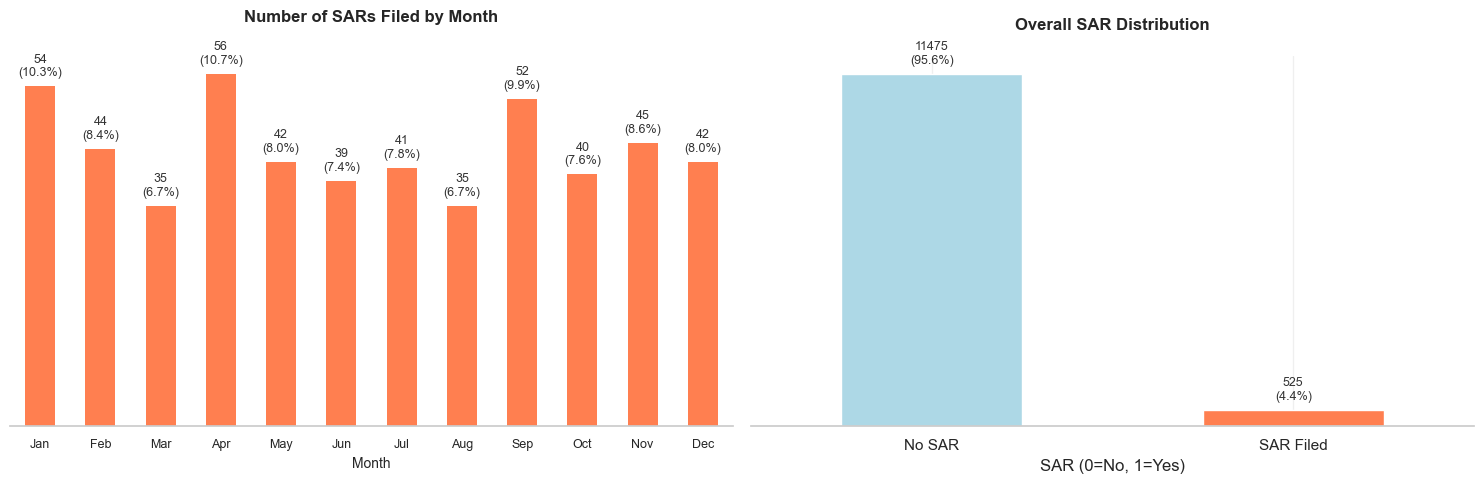

In [82]:
# Analyze SAR distribution
print("=" * 80)
print("SAR DISTRIBUTION ANALYSIS")
print("=" * 80)

# Overall SAR statistics
total_records = len(df_label)
total_sars = df_label['SAR'].sum()
sar_rate = (total_sars / total_records) * 100

print(f"Total Customer-Month Records: {total_records:,}")
print(f"Total SARs Filed: {total_sars:,}")
print(f"SAR Rate: {sar_rate:.2f}%")
print(f"Class Imbalance Ratio: {(total_records - total_sars) / total_sars:.1f}:1")

# Customer-level SAR analysis
customers_with_sar = df_label[df_label['SAR'] == 1]['Customer_ID'].nunique()
total_customers = df_label['Customer_ID'].nunique()
print(f"\nCustomers with at least one SAR: {customers_with_sar} / {total_customers} ({customers_with_sar/total_customers*100:.1f}%)")

# SAR distribution by month
sar_by_month = df_label.groupby('Month')['SAR'].agg(['sum', 'count', 'mean'])
sar_by_month['sar_rate'] = sar_by_month['mean'] * 100
print("\n" + "=" * 80)
print("SARs by Month")
print("=" * 80)
print(sar_by_month)

# Visualize SAR distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# SAR by month
# Define month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bars = sar_by_month['sum'].plot(kind='bar', ax=axes[0], color='coral', edgecolor='none')

# Title & labels
axes[0].set_title('Number of SARs Filed by Month\n', fontsize=12, fontweight='bold', pad=12)
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('')  # Remove y-label text

# Remove y-axis entirely (spine + ticks + labels)
axes[0].get_yaxis().set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Keep only bottom spine for minimalism
axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_color('#cccccc')

# Grid: subtle horizontal only (since y-axis is gone, lighter grid helps)
axes[0].grid(axis='y', color='#e0e0e0', linestyle='-', linewidth=0.7, alpha=0.7)
axes[0].set_axisbelow(True)  # grid behind bars

# Add value + % labels on bars
total = sar_by_month['sum'].sum()
max_val = sar_by_month['sum'].max()
for i, (month, count) in enumerate(sar_by_month['sum'].items()):
    if total > 0:
        pct = 100 * count / total
        label = f'{int(count)}\n({pct:.1f}%)'
    else:
        label = f'{int(count)}\n(0.0%)'
    # Slightly above bar; offset scales with data range
    offset = max_val * 0.02 if max_val > 0 else 1
    axes[0].text(i, count + offset, label,
                 ha='center', va='bottom',
                 fontsize=9, fontweight='medium', color='#333333')

# Improve x-tick appearance
axes[0].set_xticklabels(month_order, rotation=0, fontsize=9)

# Class distribution

class_bars = df_label['SAR'].value_counts().plot(kind='bar', ax=axes[1], color=['lightblue', 'coral'])
axes[1].set_title('Overall SAR Distribution\n', fontsize=12, fontweight='bold')
axes[1].set_xlabel('SAR (0=No, 1=Yes)')
axes[1].set_ylabel('') # Remove y-label text
axes[1].set_xticklabels(['No SAR', 'SAR Filed'], rotation=0)
axes[1].grid(alpha=0.3)

# Remove y-axis entirely (spine + ticks + labels)
axes[1].get_yaxis().set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Keep only bottom spine for minimalism
axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_color('#cccccc')

# Grid: subtle horizontal only (since y-axis is gone, lighter grid helps)
axes[1].grid(axis='y', color='#e0e0e0', linestyle='-', linewidth=0.7, alpha=0.7)
axes[1].set_axisbelow(True)  # grid behind bars

# Add value + % labels on bars
# Get value counts
counts = df_label['SAR'].value_counts()
total = counts.sum()
max_val=counts.max()
for i, (class_val, count) in enumerate(counts.items()):
    if total > 0:
        pct = 100 * count / total
        label = f'{int(count)}\n({pct:.1f}%)'
    else:
        label = f'{int(count)}\n(0.0%)'
    # Slightly above bar; offset scales with data range
    offset = max_val * 0.02 if max_val > 0 else 1
    axes[1].text(i, count + offset, label,
                 ha='center', va='bottom',
                 fontsize=9, fontweight='medium', color='#333333')


plt.tight_layout()
plt.show()

In [83]:
# Customer-level SAR analysis
customers_with_sar = df_label[df_label['SAR'] == 1]['Customer_ID'].nunique()
total_customers = df_label['Customer_ID'].nunique()
print(f"\nCustomers with at least one SAR: {customers_with_sar} / {total_customers} ({customers_with_sar/total_customers*100:.1f}%)")



Customers with at least one SAR: 308 / 1000 (30.8%)


## Feature Engineering from Transaction Data

In [84]:
df_transactions.head()

Customer_ID  Customer_ID_Counterparty  Transaction_Value Transaction_Type  \
0          143                       NaN               -221             Wire   
1          758                       NaN                 13             Wire   
2          485                       NaN                 25             Wire   
3          238                       NaN               -456             Wire   
4          858                       NaN                 -4             Wire   

  Month  
0   Jan  
1   Jan  
2   Jan  
3   Jan  
4   Jan

In [85]:
# Engineer features from transaction data
print("Creating transaction features per customer per month...")

# Create aggregated features
transaction_features = df_transactions.groupby(['Customer_ID', 'Month']).agg({
    'Transaction_Value': [
        'count',  # Number of transactions
        'sum',    # Total transaction value (net)
        'mean',   # Average transaction value
        'std',    # Standard deviation
        'min',    # Minimum transaction
        'max'     # Maximum transaction
    ]
}).reset_index()

# Flatten column names
transaction_features.columns = ['Customer_ID', 'Month', 'txn_count', 'txn_sum', 
                                 'txn_mean', 'txn_std', 'txn_min', 'txn_max']

# Additional features
# Turnover (sum of absolute values - excluding salary assumption)
df_transactions['abs_value'] = df_transactions['Transaction_Value'].abs()
turnover_features = df_transactions.groupby(['Customer_ID', 'Month'])['abs_value'].sum().reset_index()
turnover_features.columns = ['Customer_ID', 'Month', 'turnover']

# Count incoming vs outgoing transactions
df_transactions['incoming'] = (df_transactions['Transaction_Value'] > 0).astype(int)
df_transactions['outgoing'] = (df_transactions['Transaction_Value'] < 0).astype(int)

flow_features = df_transactions.groupby(['Customer_ID', 'Month']).agg({
    'incoming': 'sum',
    'outgoing': 'sum',
    # 'Transaction_Value': lambda x: (x > 0).sum()  # incoming count
}).reset_index()
flow_features.columns = ['Customer_ID', 'Month', 'incoming_count', 'outgoing_count']

# Calculate incoming and outgoing amounts
incoming_amt = df_transactions[df_transactions['Transaction_Value'] > 0].groupby(['Customer_ID', 'Month'])['Transaction_Value'].sum().reset_index()
incoming_amt.columns = ['Customer_ID', 'Month', 'incoming_amount']

outgoing_amt = df_transactions[df_transactions['Transaction_Value'] < 0].groupby(['Customer_ID', 'Month'])['Transaction_Value'].sum().reset_index()
outgoing_amt.columns = ['Customer_ID', 'Month', 'outgoing_amount']

# Internal transactions (transactions with counterparty that is also a customer)
internal_txn = df_transactions[df_transactions['Customer_ID_Counterparty'].notna()].groupby(['Customer_ID', 'Month']).size().reset_index()
internal_txn.columns = ['Customer_ID', 'Month', 'internal_txn_count']

# Merge all transaction features
features = transaction_features.merge(turnover_features, on=['Customer_ID', 'Month'], how='left')
features = features.merge(flow_features, on=['Customer_ID', 'Month'], how='left')
features = features.merge(incoming_amt, on=['Customer_ID', 'Month'], how='left')
features = features.merge(outgoing_amt, on=['Customer_ID', 'Month'], how='left')
features = features.merge(internal_txn, on=['Customer_ID', 'Month'], how='left')

# Fill NaN values
features['txn_std'] = features['txn_std'].fillna(0)
features['internal_txn_count'] = features['internal_txn_count'].fillna(0)
features['incoming_amount'] = features['incoming_amount'].fillna(0)
features['outgoing_amount'] = features['outgoing_amount'].fillna(0)

# Additional derived features
features['txn_range'] = features['txn_max'] - features['txn_min']
features['flow_ratio'] = features['incoming_amount'] / (features['outgoing_amount'].abs() + 1)
features['internal_txn_ratio'] = features['internal_txn_count'] / features['txn_count']

print(f"Transaction features created: {features.shape}")
print(f"Feature columns: {list(features.columns)}")
print("\nSample of transaction features:")
print(features.head(10))

Creating transaction features per customer per month...
Transaction features created: (12000, 17)
Feature columns: ['Customer_ID', 'Month', 'txn_count', 'txn_sum', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'turnover', 'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount', 'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio']

Sample of transaction features:
   Customer_ID Month  txn_count  txn_sum    txn_mean      txn_std  txn_min  \
0            1   Apr         10     -472  -47.200000  1536.561443    -2082   
1            1   Aug         16     7147  446.687500  1422.929641    -1446   
2            1   Dec         17      542   31.882353  1013.668701     -708   
3            1   Feb          9    -1193 -132.555556  1542.745694    -1367   
4            1   Jan         14     1201   85.785714  1191.352120    -1680   
5            1   Jul         10    -2008 -200.800000  1518.577756    -1669   
6            1   Jun         10       27    2.700000  1

In [86]:
# Merge with KYC and Label data
# First, merge features with labels
df_complete = features.merge(df_label, on=['Customer_ID', 'Month'], how='left')

# Then merge with KYC data
df_complete = df_complete.merge(df_kyc, on='Customer_ID', how='left')

# Convert boolean columns to int
bool_columns = ['High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 'Intention_Cash_Deposits']
for col in bool_columns:
    df_complete[col] = df_complete[col].astype(int)

# Handle Sex encoding
df_complete['Sex'] = df_complete['Sex'].map({'Male': 1, 'Female': 0})

print(f"Complete dataset shape: {df_complete.shape}")
print(f"\nColumns: {list(df_complete.columns)}")
print(f"\nMissing values:")
print(df_complete.isnull().sum())
print("\nFirst few rows:")
print(df_complete.head())

Complete dataset shape: (12000, 24)

Columns: ['Customer_ID', 'Month', 'txn_count', 'txn_sum', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'turnover', 'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount', 'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio', 'SAR', 'Age', 'Sex', 'High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 'Intention_Cash_Deposits']

Missing values:
Customer_ID                         0
Month                               0
txn_count                           0
txn_sum                             0
txn_mean                            0
txn_std                             0
txn_min                             0
txn_max                             0
turnover                            0
incoming_count                      0
outgoing_count                      0
incoming_amount                     0
outgoing_amount                     0
internal_txn_count                  0
txn_range                     

## 5. Exploratory Data Analysis (EDA)

### Correlation analysis

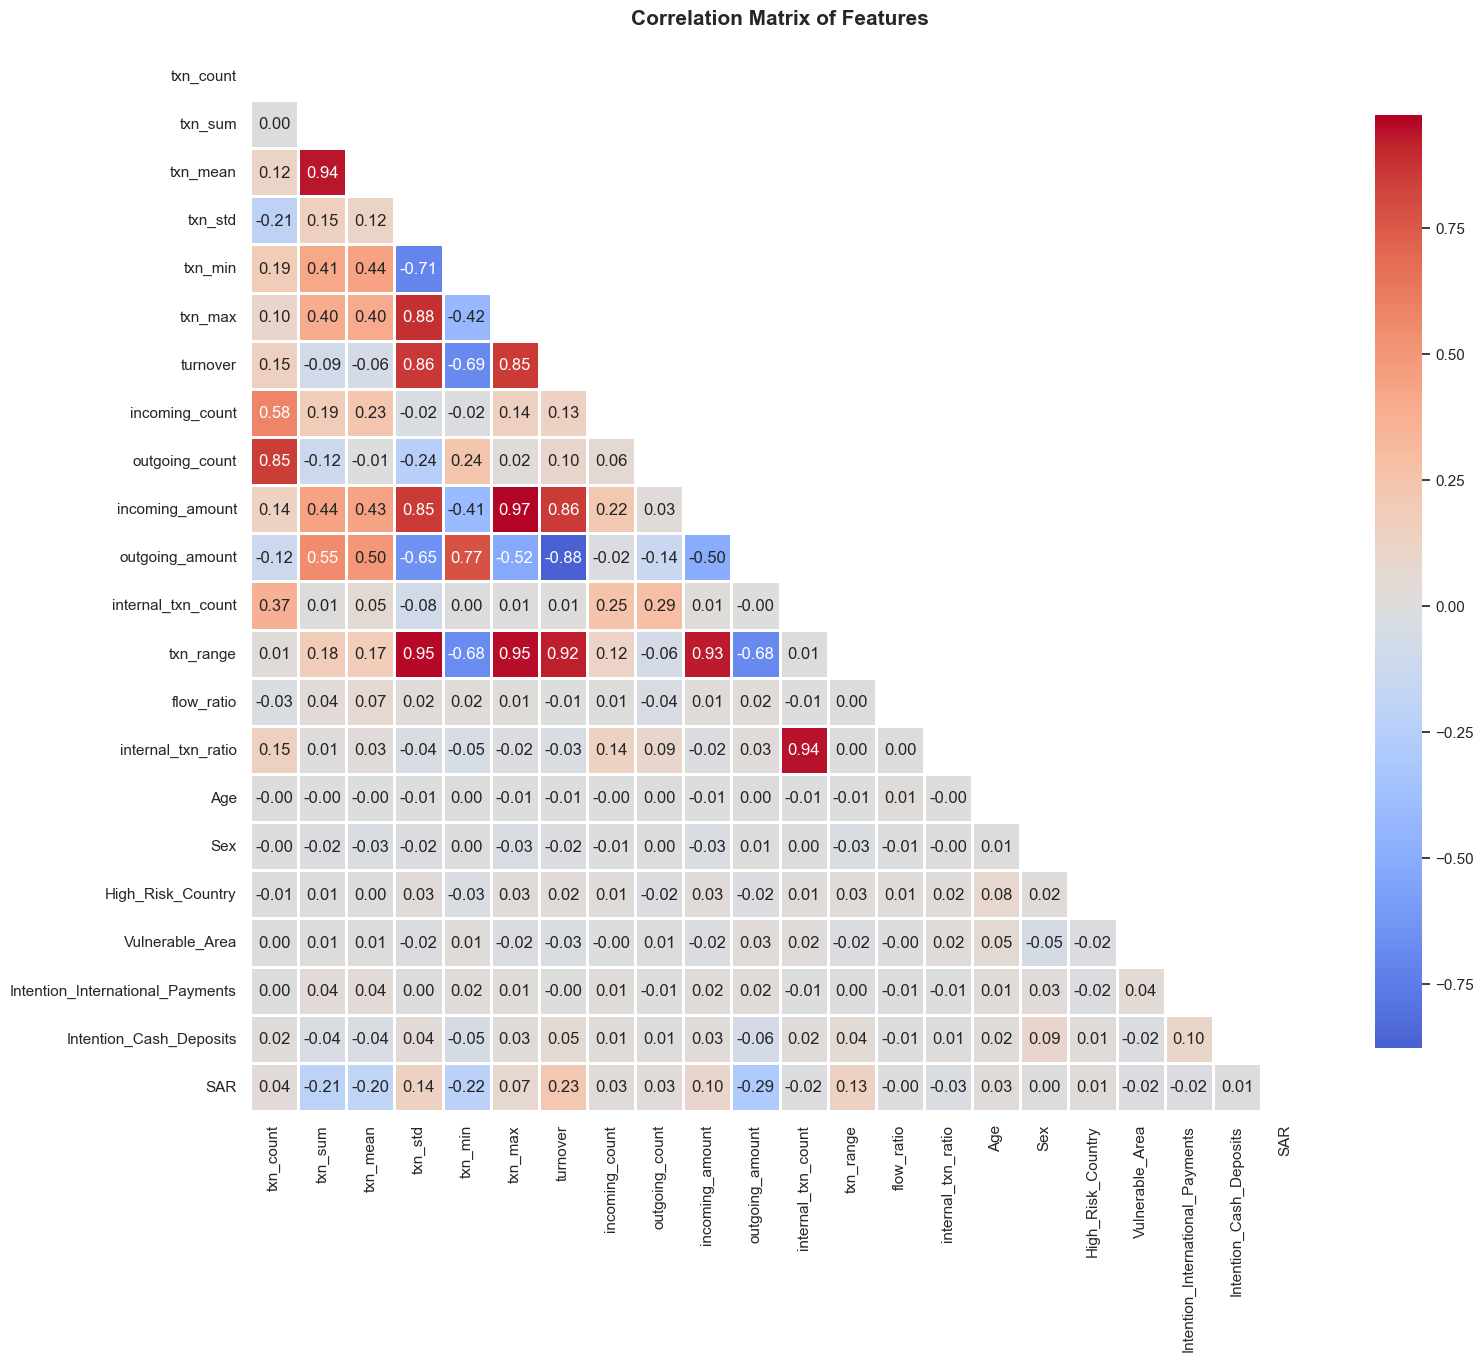


TOP FEATURES CORRELATED WITH SAR
SAR                   1.000000
outgoing_amount       0.292332
turnover              0.227714
txn_min               0.222717
txn_sum               0.212529
txn_mean              0.197391
txn_std               0.135885
txn_range             0.133637
incoming_amount       0.095196
txn_max               0.072750
txn_count             0.038192
incoming_count        0.031340
Age                   0.029446
internal_txn_ratio    0.027445
outgoing_count        0.026520
Name: SAR, dtype: float64


In [87]:

# Select numeric features for correlation
numeric_features = ['txn_count', 'txn_sum', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'turnover', 'incoming_count', 'outgoing_count',
                    'incoming_amount', 'outgoing_amount', 'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio', 'Age', 
                    'Sex', 'High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 
                    'Intention_Cash_Deposits', 'SAR']

# numeric_features = ['turnover', 'txn_count', 'txn_mean', 'txn_std', 'txn_min', 'txn_max',
#                     'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount',
#                     'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio',
#                     'Age', 'Sex', 'High_Risk_Country', 'Vulnerable_Area',
#                     'Intention_International_Payments', 'Intention_Cash_Deposits', 'SAR']

# Calculate correlation matrix
corr_matrix = df_complete[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Features', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top correlations with SAR
sar_corr = corr_matrix['SAR'].abs().sort_values(ascending=False)
print("\n" + "=" * 80)
print("TOP FEATURES CORRELATED WITH SAR")
print("=" * 80)
print(sar_corr.head(15))

### Statistical Significance

In [88]:
# Analyze feature distributions by SAR status
print("=" * 80)
print("FEATURE STATISTICS BY SAR STATUS")
print("=" * 80)

# Key transaction features
key_features = ['turnover', 'txn_count', 'txn_mean', 'txn_min', 'txn_range', 'incoming_amount', 
                    'outgoing_amount', 'internal_txn_count', 'flow_ratio', 
                    'Age', 'High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 
                    'Intention_Cash_Deposits']

comparison = df_complete.groupby('SAR')[key_features].mean()
print("\nMean values by SAR status:")
print(comparison.round(2))

# Statistical significance
from scipy import stats
print("\n" + "=" * 80)
print("STATISTICAL TESTS (SAR vs No SAR)")
print("=" * 80)

for feature in key_features:
    sar_data = df_complete[df_complete['SAR'] == 1][feature]
    no_sar_data = df_complete[df_complete['SAR'] == 0][feature]
    
    # T-test
    t_stat, p_value = stats.ttest_ind(sar_data.dropna(), no_sar_data.dropna())
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "NS"
    
    print(f"{feature:<25} p-value: {p_value:.6f} {significance}")

print("\n*** p < 0.001, ** p < 0.01, * p < 0.05, NS = Not Significant")

FEATURE STATISTICS BY SAR STATUS

Mean values by SAR status:
     turnover  txn_count  txn_mean  txn_min  txn_range  incoming_amount  \
SAR                                                                       
0    10487.01      13.78   -106.30 -1792.78    6090.00          4567.90   
1    17038.62      14.50   -389.68 -3190.10    8592.62          6085.75   

     outgoing_amount  internal_txn_count  flow_ratio    Age  \
SAR                                                           
0           -5919.11                1.21        2.03  51.09   
1          -10952.88                1.10        0.62  53.97   

     High_Risk_Country  Vulnerable_Area  Intention_International_Payments  \
SAR                                                                         
0                 0.21             0.09                              0.41   
1                 0.24             0.06                              0.36   

     Intention_Cash_Deposits  
SAR                           
0             

### Visualize key features by SAR status

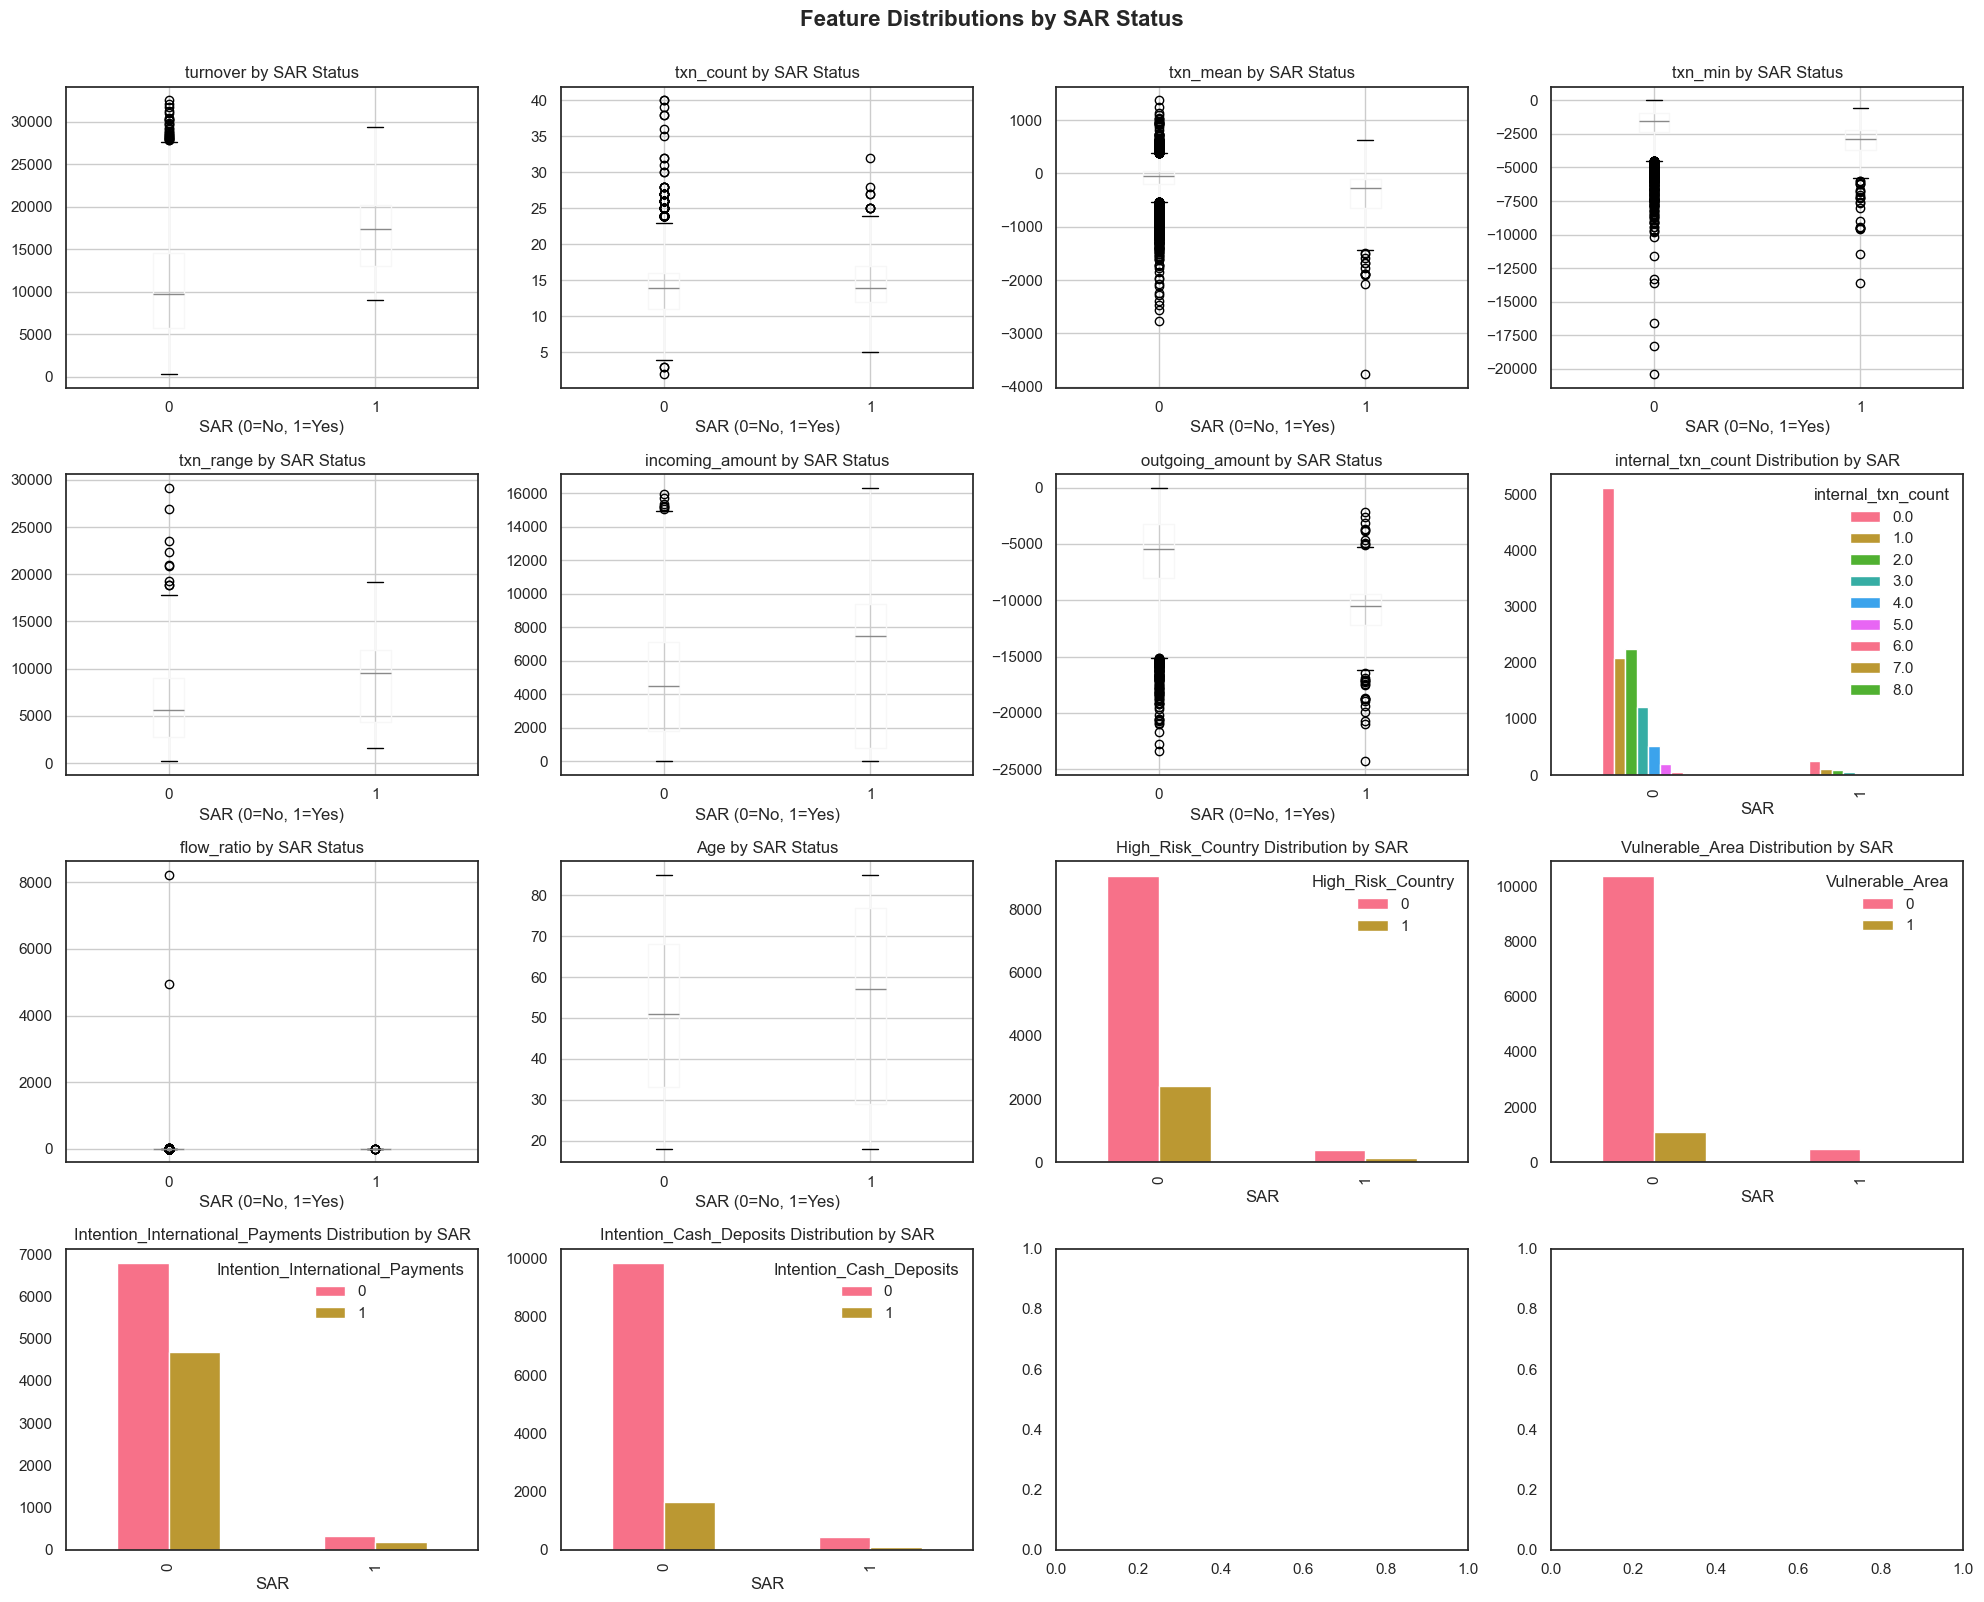

In [89]:
# Visualize key features by SAR status
fig, axes = plt.subplots(4, 4, figsize=(20, 16))  # 16 subplots
axes = axes.flatten()

features_to_plot = ['turnover', 'txn_count', 'txn_mean', 'txn_min', 'txn_range', 'incoming_amount', 
                    'outgoing_amount', 'internal_txn_count', 'flow_ratio', 
                    'Age', 'High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 
                    'Intention_Cash_Deposits']

for idx, feature in enumerate(features_to_plot):
    if feature in df_complete.columns:
        # Box plot for continuous variables
        if df_complete[feature].nunique() > 10:
            df_complete.boxplot(column=feature, by='SAR', ax=axes[idx])
            axes[idx].set_title(f'{feature} by SAR Status')
            axes[idx].set_xlabel('SAR (0=No, 1=Yes)')
        else:
            # Bar plot for categorical/binary variables
            df_complete.groupby(['SAR', feature]).size().unstack(fill_value=0).plot(kind='bar', ax=axes[idx])
            axes[idx].set_title(f'{feature} Distribution by SAR')
            axes[idx].set_xlabel('SAR')
            axes[idx].legend(title=feature)

plt.suptitle('Feature Distributions by SAR Status', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Current Rule Performance Analysis (€9,000 Threshold)

CURRENT RULE PERFORMANCE: Turnover > €9,000

Confusion Matrix:
True Negatives (TN):  5,299
False Positives (FP): 6,176
False Negatives (FN): 0
True Positives (TP):  525

Metric                    Value     
-----------------------------------
Precision                 0.0783
Recall (Detection Rate)   1.0000
F1-Score                  0.1453
False Positive Rate       0.5382
Customers Flagged         6,701
% of Customers Flagged    55.84%

SAR Detection             Count     
-----------------------------------
Total SARs                525
Detected by Rule          525
Missed by Rule            0
Detection Rate            100.00%


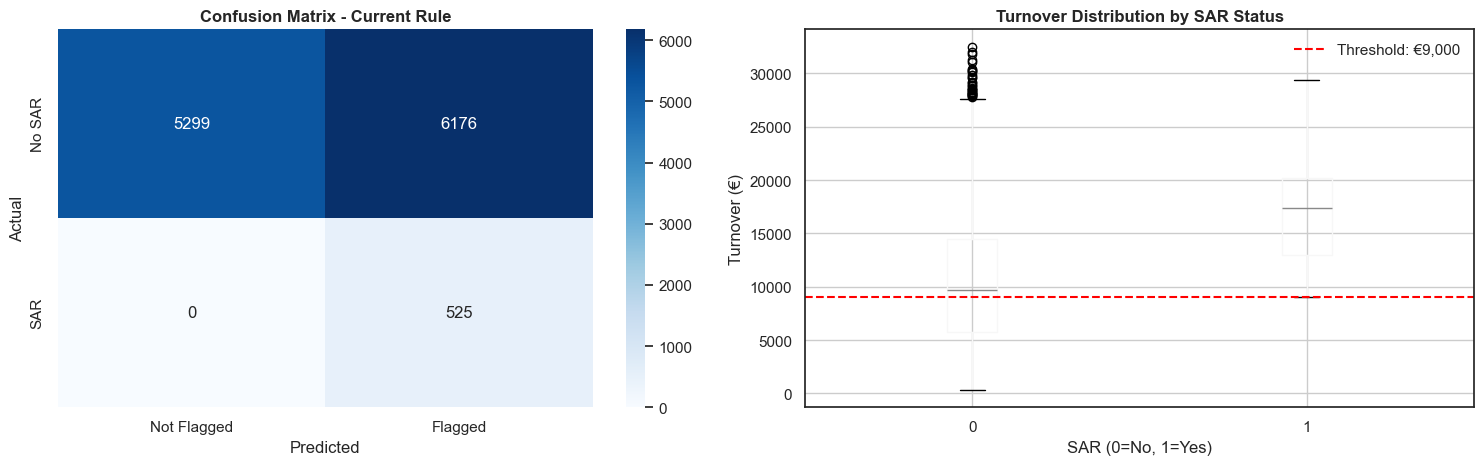

In [90]:
# Evaluate current rule: turnover > 9000 EUR
threshold = 9000
df_complete['current_rule_flag'] = (df_complete['turnover'] > threshold).astype(int)

# Calculate metrics
from sklearn.metrics import confusion_matrix, classification_report

print("=" * 80)
print(f"CURRENT RULE PERFORMANCE: Turnover > €{threshold:,}")
print("=" * 80)

# Confusion matrix
cm = confusion_matrix(df_complete['SAR'], df_complete['current_rule_flag'])
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"True Negatives (TN):  {tn:,}")
print(f"False Positives (FP): {fp:,}")
print(f"False Negatives (FN): {fn:,}")
print(f"True Positives (TP):  {tp:,}")

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"\n{'Metric':<25} {'Value':<10}")
print("-" * 35)
print(f"{'Precision':<25} {precision:.4f}")
print(f"{'Recall (Detection Rate)':<25} {recall:.4f}")
print(f"{'F1-Score':<25} {f1:.4f}")
print(f"{'False Positive Rate':<25} {fpr:.4f}")
print(f"{'Customers Flagged':<25} {(fp + tp):,}")
print(f"{'% of Customers Flagged':<25} {((fp + tp) / len(df_complete) * 100):.2f}%")

# Additional insights
total_sars = df_complete['SAR'].sum()
detected_sars = tp
missed_sars = fn

print(f"\n{'SAR Detection':<25} {'Count':<10}")
print("-" * 35)
print(f"{'Total SARs':<25} {total_sars:,}")
print(f"{'Detected by Rule':<25} {detected_sars:,}")
print(f"{'Missed by Rule':<25} {missed_sars:,}")
print(f"{'Detection Rate':<25} {(detected_sars/total_sars*100):.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Flagged', 'Flagged'], 
            yticklabels=['No SAR', 'SAR'])
axes[0].set_title('Confusion Matrix - Current Rule', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Turnover distribution by SAR
df_complete.boxplot(column='turnover', by='SAR', ax=axes[1])
axes[1].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: €{threshold:,}')
axes[1].set_title('Turnover Distribution by SAR Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('SAR (0=No, 1=Yes)')
axes[1].set_ylabel('Turnover (€)')
axes[1].legend()
plt.suptitle('')

plt.tight_layout()
plt.show()

## Machine Learning Model Development

### Prepare data for modeling

In [91]:
df_complete.columns

Index(['Customer_ID', 'Month', 'txn_count', 'txn_sum', 'txn_mean', 'txn_std',
       'txn_min', 'txn_max', 'turnover', 'incoming_count', 'outgoing_count',
       'incoming_amount', 'outgoing_amount', 'internal_txn_count', 'txn_range',
       'flow_ratio', 'internal_txn_ratio', 'SAR', 'Age', 'Sex',
       'High_Risk_Country', 'Vulnerable_Area',
       'Intention_International_Payments', 'Intention_Cash_Deposits',
       'current_rule_flag'],
      dtype='object')

In [92]:
# Select features
feature_columns = ['txn_count', 'txn_mean', 'txn_min', 'txn_range', 'turnover',
                   'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount',
                   'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio',
                   'Age', 'Sex', 'High_Risk_Country', 'Vulnerable_Area',
                   'Intention_International_Payments', 'Intention_Cash_Deposits']

X = df_complete[feature_columns].copy()
y = df_complete['SAR'].copy()

# Handle any remaining NaN values
X = X.fillna(0)

# Handle infinite values
X = X.replace([np.inf, -np.inf], 0)

print("=" * 80)
print("DATA PREPARATION FOR MODELING")
print("=" * 80)
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass imbalance ratio: {(y==0).sum() / (y==1).sum():.1f}:1")

# Split data - using stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set SAR rate: {y_train.mean()*100:.2f}%")
print(f"Test set SAR rate: {y_test.mean()*100:.2f}%")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")

DATA PREPARATION FOR MODELING
Feature matrix shape: (12000, 19)
Target variable shape: (12000,)
Number of features: 19

Class distribution:
SAR
0    11475
1      525
Name: count, dtype: int64

Class imbalance ratio: 21.9:1

Training set: 9600 samples
Test set: 2400 samples

Training set SAR rate: 4.38%
Test set SAR rate: 4.38%

Features scaled using StandardScaler


### Model 1: Logistic Regression

MODEL 1: LOGISTIC REGRESSION

Classification Report:
              precision    recall  f1-score   support

      No SAR       0.99      0.82      0.90      2295
         SAR       0.18      0.89      0.30       105

    accuracy                           0.82      2400
   macro avg       0.59      0.85      0.60      2400
weighted avg       0.96      0.82      0.87      2400


Confusion Matrix:
[[1876  419]
 [  12   93]]

ROC-AUC Score: 0.9004
AUC-PR (Average Precision): 0.2076

Top 10 Most Important Features (by coefficient magnitude):
                             Feature  Coefficient
4                           turnover     1.593331
7                    incoming_amount     1.410773
10                         txn_range    -1.404151
3                          txn_range    -1.404151
8                    outgoing_amount    -1.355821
2                            txn_min    -0.827766
12                internal_txn_ratio    -0.212711
16                   Vulnerable_Area    -0.212026
9     

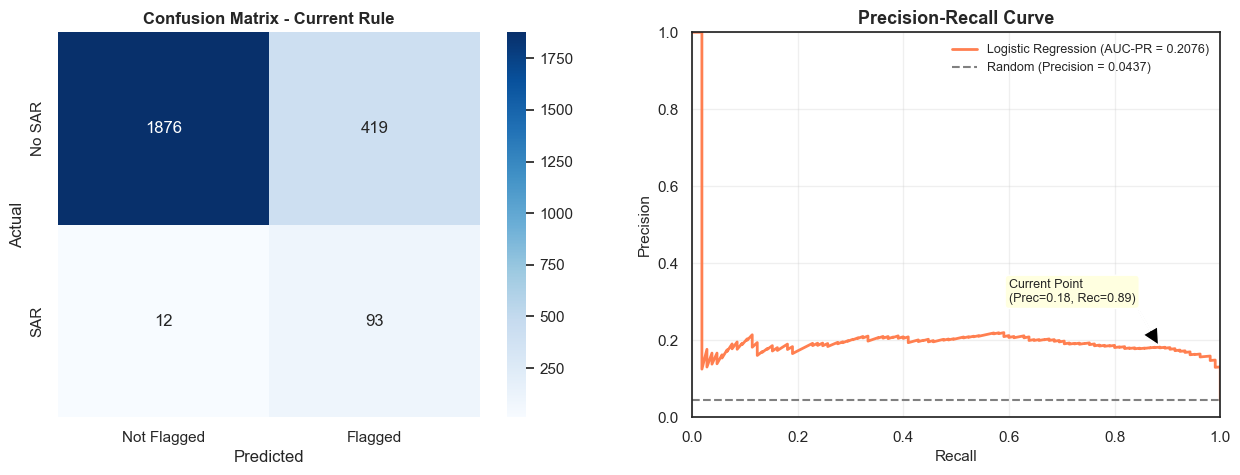

In [93]:
# Model 1: Logistic Regression with class weights
print("=" * 80)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 80)

# Calculate class weights to handle imbalance
class_weight_ratio = (y_train == 0).sum() / (y_train == 1).sum()
class_weights = {0: 1, 1: class_weight_ratio}

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No SAR', 'SAR']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm_lr)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Flagged', 'Flagged'], 
            yticklabels=['No SAR', 'SAR'])
axes[0].set_title('Confusion Matrix - Current Rule', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC-AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nROC-AUC Score: {roc_auc_lr:.4f}")

# Compute AUC-PR (also called Average Precision)
auc_pr = average_precision_score(y_test, y_pred_proba_lr)
print(f"AUC-PR (Average Precision): {auc_pr:.4f}")

# Visualize PR Curve
# Compute PR curve points
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_lr)

# Plot on axes[1]
axes[1].plot(recall, precision, color='coral', linewidth=2,
             label=f'Logistic Regression (AUC-PR = {auc_pr:.4f})')

# Baseline: random classifier = prevalence of SAR in test set
baseline = y_test.mean()  # ~0.04375
axes[1].axhline(y=baseline, color='gray', linestyle='--',
                label=f'Random (Precision = {baseline:.4f})')

# Customize plot
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve', fontweight='bold', fontsize=13)
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
legend = axes[1].legend(loc='upper right', fontsize=9)

# Add text annotation for current operating point
current_prec = precision_score(y_test, y_pred_lr)  # from classification report
current_rec = recall_score(y_test, y_pred_lr)
axes[1].annotate(f'Current Point\n(Prec={current_prec:.2f}, Rec={current_rec:.2f})',
                 xy=(current_rec, current_prec),
                 xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                 fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (by coefficient magnitude):")
print(feature_importance_lr.head(20))

### Model 2: Random Forest Classifier

MODEL 2: RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

      No SAR       0.99      0.86      0.92      2295
         SAR       0.19      0.73      0.30       105

    accuracy                           0.85      2400
   macro avg       0.59      0.80      0.61      2400
weighted avg       0.95      0.85      0.89      2400


Confusion Matrix:
[[1969  326]
 [  28   77]]

ROC-AUC Score: 0.9114
AUC-PR (Average Precision): 0.3110

Top 10 Most Important Features:
                             Feature  Importance
8                    outgoing_amount    0.331568
4                           turnover    0.169461
2                            txn_min    0.107961
1                           txn_mean    0.072638
7                    incoming_amount    0.067226
11                        flow_ratio    0.053149
3                          txn_range    0.050416
10                         txn_range    0.048180
13                               Age    0.024990

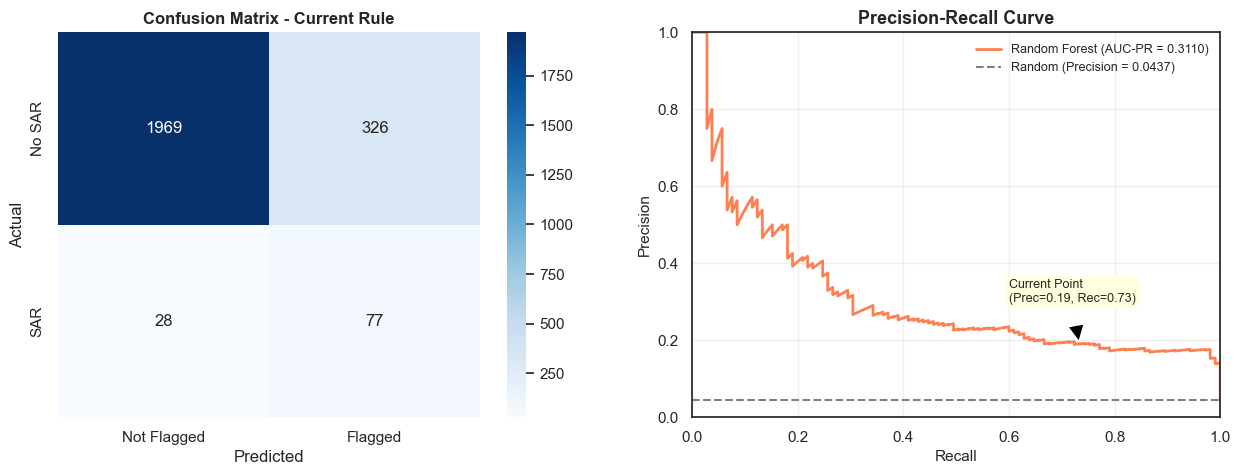

In [94]:
# Model 2: Random Forest Classifier
print("=" * 80)
print("MODEL 2: RANDOM FOREST")
print("=" * 80)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20, 
                                   class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No SAR', 'SAR']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Flagged', 'Flagged'], 
            yticklabels=['No SAR', 'SAR'])
axes[0].set_title('Confusion Matrix - Current Rule', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nROC-AUC Score: {roc_auc_rf:.4f}")

# Compute AUC-PR (also called Average Precision)
auc_pr = average_precision_score(y_test, y_pred_proba_rf)
print(f"AUC-PR (Average Precision): {auc_pr:.4f}")

# Visualize PR Curve
# Compute PR curve points
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)

# Plot on axes[1]
axes[1].plot(recall, precision, color='coral', linewidth=2,
             label=f'Random Forest (AUC-PR = {auc_pr:.4f})')

# Baseline: random classifier = prevalence of SAR in test set
baseline = y_test.mean()  # ~0.04375
axes[1].axhline(y=baseline, color='gray', linestyle='--',
                label=f'Random (Precision = {baseline:.4f})')

# Customize plot
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve', fontweight='bold', fontsize=13)
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])

# Fix legend: move text away from line
legend = axes[1].legend(loc='upper right', fontsize=9)
        
# Add text annotation for current operating point
current_prec = precision_score(y_test, y_pred_rf)  # from classification report
current_rec = recall_score(y_test, y_pred_rf)
axes[1].annotate(f'Current Point\n(Prec={current_prec:.2f}, Rec={current_rec:.2f})',
                 xy=(current_rec, current_prec),
                 xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                 fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(20))

## Model Comparison and Evaluation

In [95]:
# Compare all models including baseline
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Calculate metrics for all models
models = {
    'Current Rule (€9k)': {
        'predictions': df_complete.loc[X_test.index, 'current_rule_flag'],
        'probabilities': None
    },
    'Logistic Regression': {
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr
    },
    'Random Forest': {
        'predictions': y_pred_rf,
        'probabilities': y_pred_proba_rf
    }
}

results = []
for model_name, preds in models.items():
    y_pred = preds['predictions']
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Calculate confusion matrix elements
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # ROC-AUC (only for models with probabilities)
    roc_auc = roc_auc_score(y_test, preds['probabilities']) if preds['probabilities'] is not None else 'N/A'
    # Compute AUC-PR (also called Average Precision)
    auc_pr = average_precision_score(y_test, preds['probabilities']) if preds['probabilities'] is not None else 'N/A'
    
    results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc if isinstance(roc_auc, str) else f"{roc_auc:.4f}",
        'AUC-PR': auc_pr if isinstance(auc_pr, str) else f"{auc_pr:.4f}",
        'False Positive Rate': fpr,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'True Negatives': tn
    })

results_df = pd.DataFrame(results)
print("\nPerformance Metrics:")
print(results_df.to_string(index=False))

# Key insights
print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

best_recall_idx = results_df['Recall'].idxmax()
best_precision_idx = results_df['Precision'].idxmax()
best_f1_idx = results_df['F1-Score'].idxmax()

print(f"\n• Best Recall (Detection Rate): {results_df.iloc[best_recall_idx]['Model']} ({results_df.iloc[best_recall_idx]['Recall']:.2%})")
print(f"• Best Precision (Lowest False Positives): {results_df.iloc[best_precision_idx]['Model']} ({results_df.iloc[best_precision_idx]['Precision']:.2%})")
print(f"• Best F1-Score (Balance): {results_df.iloc[best_f1_idx]['Model']} ({results_df.iloc[best_f1_idx]['F1-Score']:.4f})")

MODEL COMPARISON SUMMARY

Performance Metrics:
              Model  Precision   Recall  F1-Score ROC-AUC AUC-PR  False Positive Rate  True Positives  False Positives  False Negatives  True Negatives
 Current Rule (€9k)   0.078711 1.000000  0.145935     N/A    N/A             0.535512             105             1229                0            1066
Logistic Regression   0.181641 0.885714  0.301459  0.9004 0.2076             0.182571              93              419               12            1876
      Random Forest   0.191067 0.733333  0.303150  0.9114 0.3110             0.142048              77              326               28            1969

KEY INSIGHTS

• Best Recall (Detection Rate): Current Rule (€9k) (100.00%)
• Best Precision (Lowest False Positives): Random Forest (19.11%)
• Best F1-Score (Balance): Random Forest (0.3031)


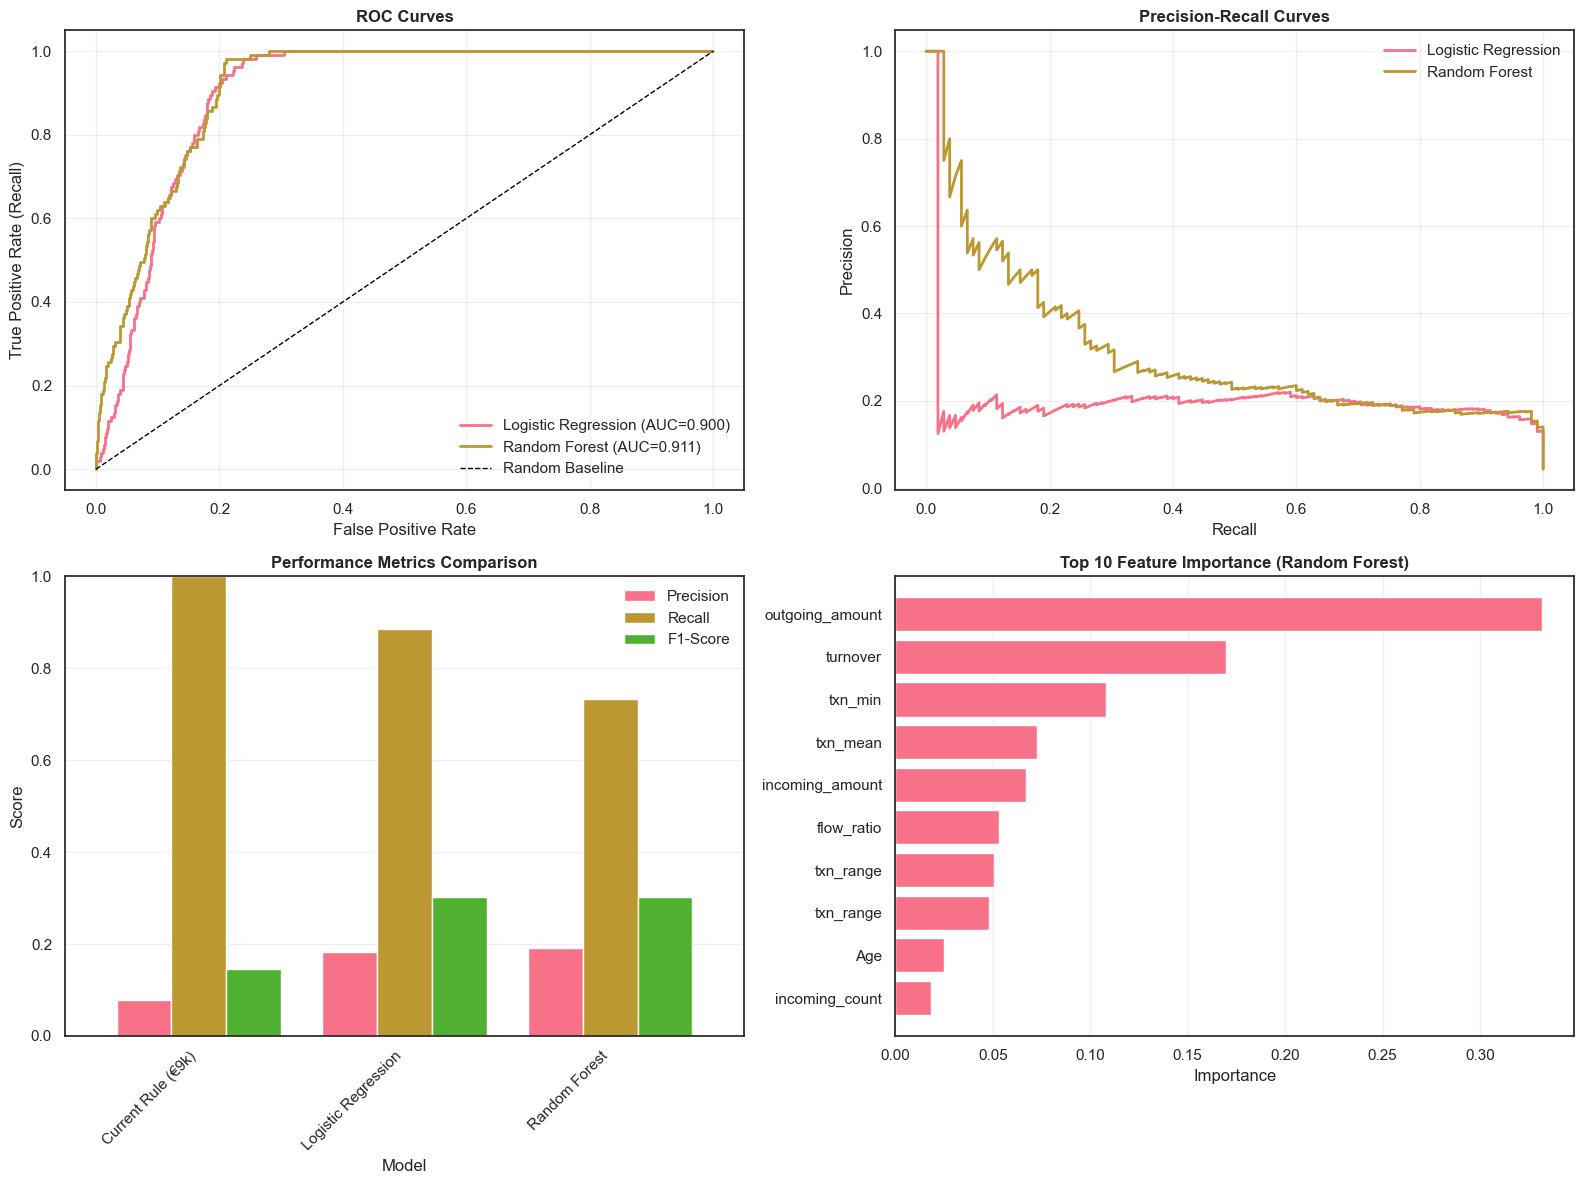

In [96]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

axes[0, 0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_lr:.3f})', linewidth=2)
axes[0, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random Baseline', linewidth=1)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate (Recall)')
axes[0, 0].set_title('ROC Curves', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Precision-Recall Curves
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)

axes[0, 1].plot(recall_lr, precision_lr, label='Logistic Regression', linewidth=2)
axes[0, 1].plot(recall_rf, precision_rf, label='Random Forest', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curves', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Metrics Comparison Bar Chart
metrics_comparison = results_df[['Model', 'Precision', 'Recall', 'F1-Score']].copy()
metrics_comparison = metrics_comparison.set_index('Model')
metrics_comparison.plot(kind='bar', ax=axes[1, 0], width=0.8)
axes[1, 0].set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_xticklabels(metrics_comparison.index, rotation=45, ha='right')

# 4. Feature Importance (Random Forest)
top_features = feature_importance_rf.head(10)
axes[1, 1].barh(range(len(top_features)), top_features['Importance'])
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Feature'])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importance (Random Forest)', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [74]:
# Save the trained model and scaler for deployment
import pickle

# Save Random Forest model
with open('rf_sar_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save feature scaler (if needed for scaled features)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print("Model artifacts saved successfully!")
print("- rf_sar_model.pkl: Trained Random Forest model")
print("- feature_scaler.pkl: Feature scaler")
print("- feature_names.pkl: Feature column names")
print("\nThese can be loaded for deployment in production systems.")

Model artifacts saved successfully!
- rf_sar_model.pkl: Trained Random Forest model
- feature_scaler.pkl: Feature scaler
- feature_names.pkl: Feature column names

These can be loaded for deployment in production systems.
